# Interpolation of Model Spectra

When interpolating model spectra, the interpolation error can accumulate away from grid points. If you have high S/N spectra this can be an issue as the interpolation error is naturally smaller near the grid points. Since this is an additional source of discrepancy between your data and your model, it can lead to your spectral fits being attracted to the grid points (see Cottar et al 2014, ApJ, 794, 125).

In this notebook, we explore how bad this is for WDs, using the Koester DA model grid downloaded from VOSA.

In [1]:
from preprocess import process_grid
from emulator import Emulator
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-notebook')

## Data Cleaning

The Koester model grid is not as nice as we'd like. Each individual model has a slightly different wavelength solution. The function below uses spline interpolation to put them all on an identical wavelength grid. At the same time we restrict the wavelength range to $300--900$ nm. 

The result is a list of temperatures and gravities, the wavelength grid and a $(N_T, N_g, N_{\rm spectra})$ shaped array containing the models.

In [2]:
teffs, gravities, wref, spectra = process_grid('/Users/sl/Downloads/koester', [3000, 9000])

## Spectral Emulation

It is often said that the best way to emulate a model grid is to use Principle Component Analysis (PCA) to *decompose* the model grid into a series of *eigenspectra*. Each spectrum in the grid can in principle be represented as the weighted sum of the eigenspectra.

The class below handles the PCA for us. We let Scikit-Learn's PCA class set the number of components, by requiring that the PCA can explain a set fraction of the total variance within the model grid. 

Spectra are normalised so the PCA doesn't simply learn the increase in flux with temperature, for example.

In [4]:
emu = Emulator(wref, teffs, gravities, spectra)
explained_variance = emu.run_pca(target_variance=0.9995)
print(f"PCA explained {100*explained_variance:.2f} of variance in model grid with {emu.ncomps} components")

PCA explained 99.96 of variance in model grid with 8 components


### The Eigenspectra

What do the eigenspectra look like? They don't look particularly physical!

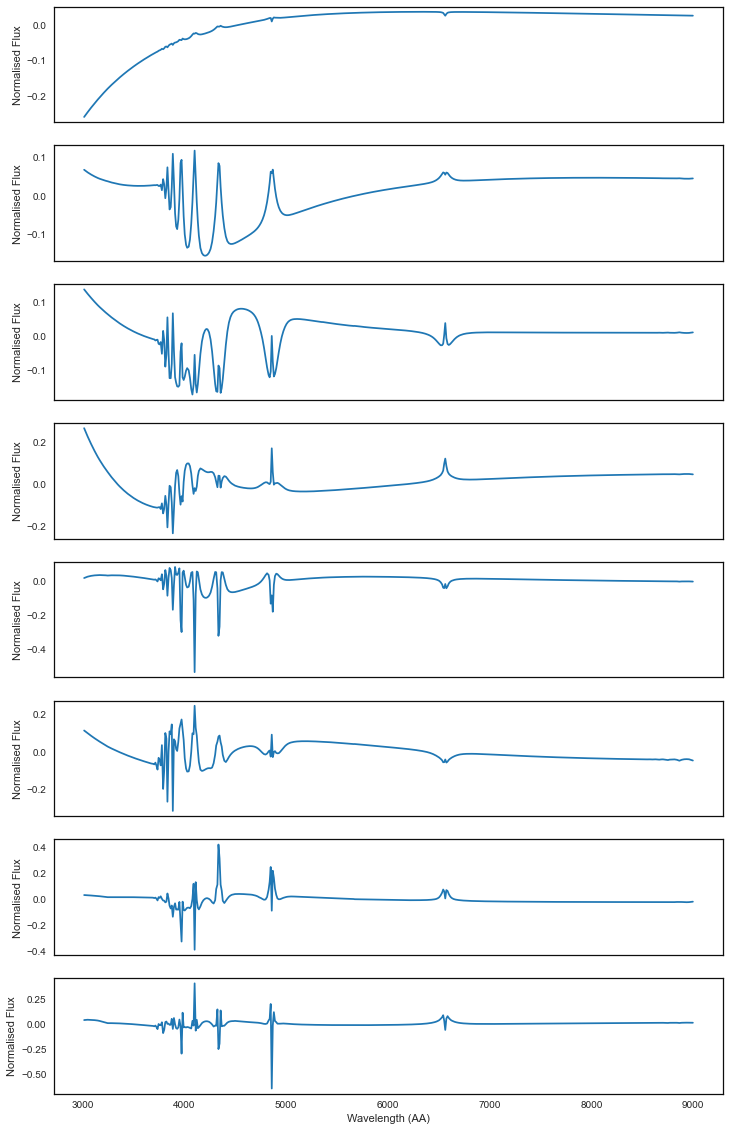

In [5]:
fig, axes = plt.subplots(nrows=len(emu.eigenspectra), sharex=True, figsize=(12, 20))
for ax, spec in zip(axes, emu.eigenspectra):
    ax.plot(wref, spec)
    ax.set_ylabel('Normalised Flux')
axes[-1].set_xlabel('Wavelength (AA)');


### The Weight Maps

It's more interesting to look at the weight maps! These plot the amount of weight to apply to each eigenspectrum to recover the original spectrum, as a function of temperature and gravity.

The point here is that these maps are **smooth**, so if we want to recreate a spectrum at a temperature and gravity that are not on the grid, we can interpolate these **maps** accurately, to find the weights for each eigenspectrum.

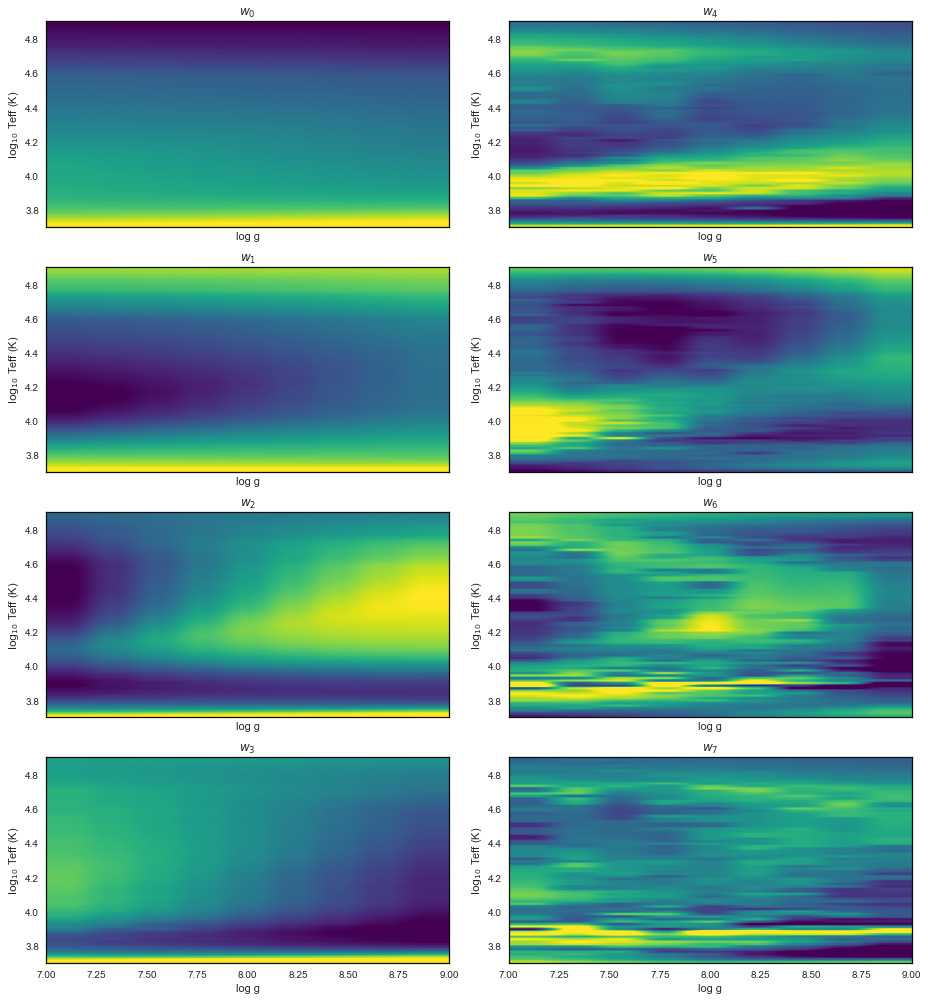

In [6]:
emu.plot_component_weights()

Note that the higher order components are getting a bit noisy. Perhaps we might reduce the target variance if we see problems.

# Performance

In the cell below I use the weight maps to emulate a spectrum that is on the grid. An emulated spectrum is done by interpolating the maps above using Delaunay triangulation via SciPy's `LinearNDInterpolator` - I have found this the most accurate way to interpolate on 2D grids. 

Once we have interpolated the maps to find the correct weights, we can reconstruct the spectrum as a weighted sum of the eigenvectors. This is fast.

In [7]:
actual_spectrum = spectra[31, 5]
teff = teffs[31]
logg = gravities[5]

# emulate the spectrum
%time recovered = emu([np.log10(teff), logg])

CPU times: user 14.7 ms, sys: 5.36 ms, total: 20 ms
Wall time: 26.9 ms


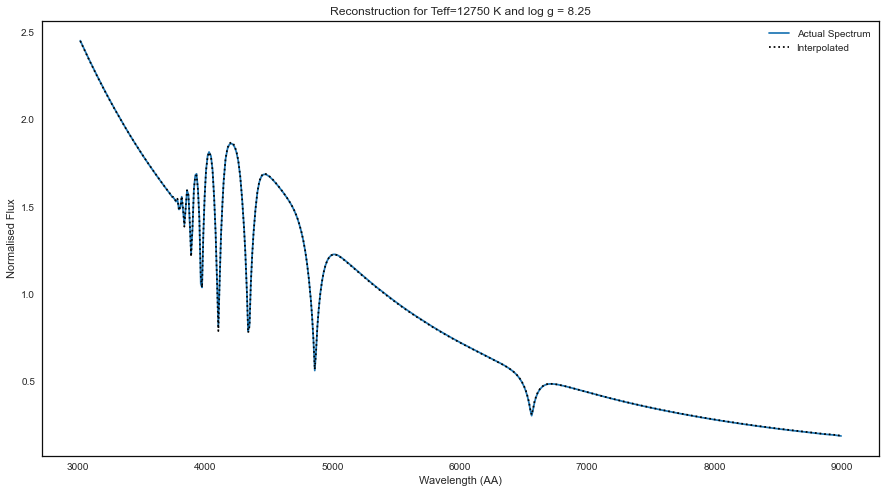

In [8]:
fig = plt.figure(figsize=(15,8))
plt.plot(wref, actual_spectrum/actual_spectrum.mean(), label='Actual Spectrum')
plt.plot(wref, recovered, 'k:', label='Interpolated')
plt.xlabel('Wavelength (AA)')
plt.ylabel('Normalised Flux')
plt.title(f'Reconstruction for Teff={teff} K and log g = {logg}')
plt.legend();

Performance looks OK, but this is not the best test. In the cells below I create a new emulator, this time using only *half* the grid-points.

PCA explained 99.96 of variance in model grid with 8 components


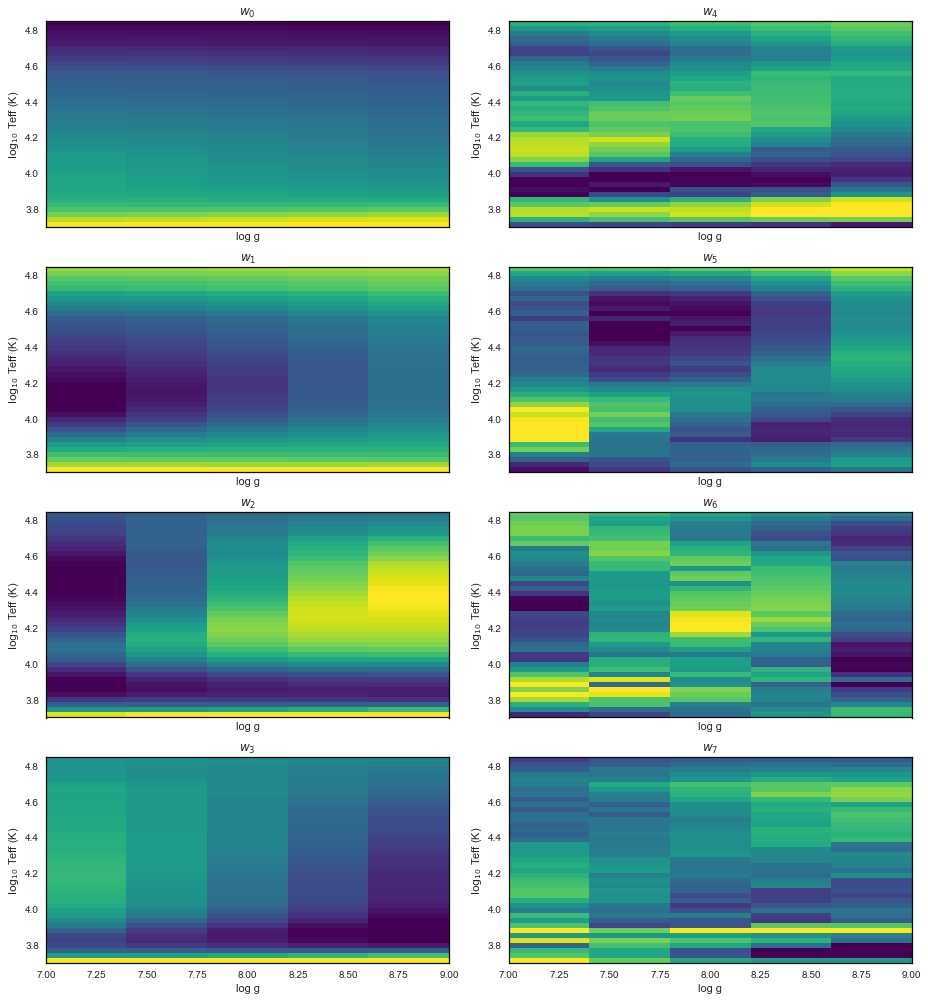

In [9]:
emu2 = Emulator(wref, teffs[::2], gravities[::2], spectra[::2, ::2, :])
explained_variance = emu2.run_pca(target_variance=0.9995)
print(f"PCA explained {100*explained_variance:.2f} of variance in model grid with {emu2.ncomps} components")
emu2.plot_component_weights()

Let's see how this emulator does in recreating the original spectrum, which is **not** on the grid passed to the emulator. 

We also compare this to the result of using Scipy's `LinearNDInterpolator` on the model spectra themselves, which is how I would normally do this interpolation.

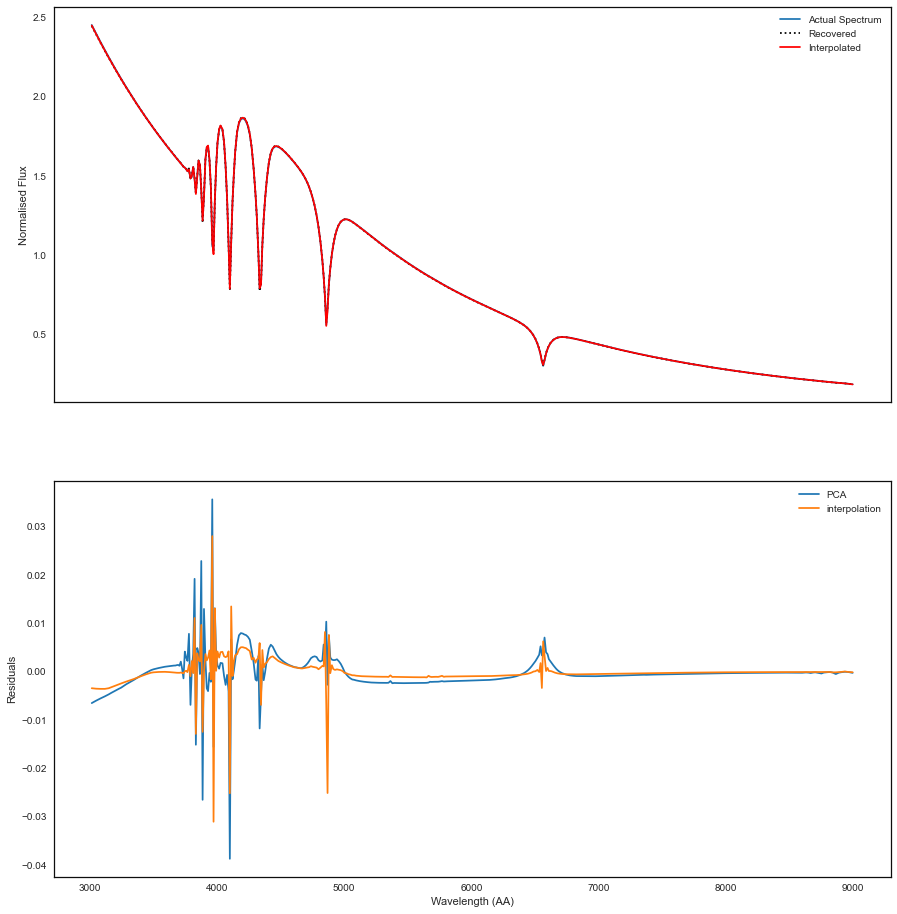

In [10]:
# use emulation to reconstruct the spectrum
recovered = emu2([np.log10(teff), logg])

# just interpolate the spectral model grid
recovered_interpolation = emu2.linear_interpolation([np.log10(teff), logg])

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,16), sharex=True)
ax1.plot(wref, actual_spectrum/actual_spectrum.mean(), label='Actual Spectrum')
ax1.plot(wref, recovered, 'k:', label='Recovered')
ax1.plot(wref, recovered_interpolation, 'r-', label='Interpolated')
ax2.plot(wref, recovered - actual_spectrum/actual_spectrum.mean(), label='PCA')
ax2.plot(wref, recovered_interpolation - actual_spectrum/actual_spectrum.mean(), label='interpolation')
ax2.set_xlabel('Wavelength (AA)')
ax1.set_ylabel('Normalised Flux')
ax2.set_ylabel('Residuals')
ax2.legend()
ax1.legend();

If you look at the residuals, you can see that PCA emulation is not really any better than interpolation when considering the size of the residuals. There are some qualitative differences. Interpolation tends to cause errors in the cores of the lines, where the spectra are changing most rapidly. Emulation has smoother residuals, but they are larger in amplitude and affect the line *shapes* more.

This is only for one spectrum. Let's write a little helper function to calcualte the RMS deviation of the interpolated and emulated spectrum at every point on the original grid.

In [11]:
def test_residual(t_idx, g_idx):
    actual_spectrum = spectra[t_idx, g_idx]
    actual_spectrum /= actual_spectrum.mean()
    teff = teffs[t_idx]
    logg = gravities[g_idx]
    logt = np.log10(teff)
    emulated = emu2([logt, logg])
    interpolated = emu2.linear_interpolation([logt, logg])
    residuals_emulated = (emulated-actual_spectrum)/actual_spectrum
    residuals_interpolated = (interpolated-actual_spectrum)/actual_spectrum
    return np.std(residuals_emulated), np.std(residuals_interpolated)

And let's run it on the entire Koester model grid.

In [12]:
emulated_residuals = np.empty((emu.nteffs, emu.nlogg))
interpolated_residuals = np.empty((emu.nteffs, emu.nlogg))
for t_idx in range(emu.nteffs):
    for g_idx in range(emu.nlogg):
        err_em, err_int = test_residual(t_idx, g_idx)
        emulated_residuals[t_idx, g_idx] = err_em
        interpolated_residuals[t_idx, g_idx] = err_int

## Results

The plot below shows the results. I've plotted the fractional error in the spectrum as a function of log g and Teff for every spectrum on the Koester grid. Remember; the interpolated and emulated spectra were created using a reduced grid of half the model spectra.

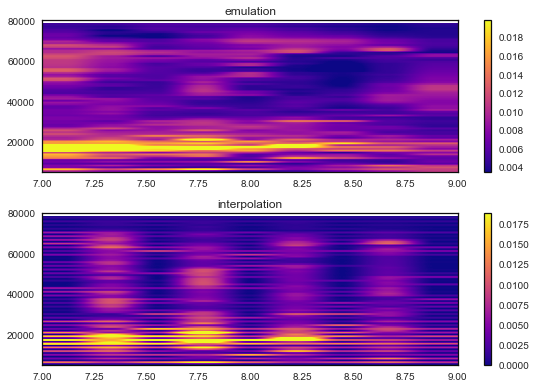

In [13]:
from sl.visualisation import imshow
fig, axes = plt.subplots(nrows=2)
extents = (gravities.min(), gravities.max(), teffs.min(), teffs.max())
fig1 = imshow(emulated_residuals, axis=axes[0], aspect='auto', extent=extents)
fig2 = imshow(interpolated_residuals, axis=axes[1], aspect='auto', extent=extents)
cbar = fig.colorbar(fig1, ax=axes[0])
cbar2 = fig.colorbar(fig2, ax=axes[1])
axes[0].set_title('emulation')
axes[1].set_title('interpolation')
fig.tight_layout()
fig.savefig('/Users/sl/Desktop/performance.pdf')

## Discussion

We can see that the emulated spectra have similar fractional errors **in this case**. Note that I had to tune the target variance for the PCA to get this result. At a target variance of 99.5%, the PCA used 6 components and had fractional errors roughly twice that of the interpolated spectra.

What is quite noticeable here is the that interpolated errors do show a regular pattern as we might expect, with spectra off the grid showing larger errors. The emulated spectra don't show this pattern, and so may be a better choice. 

Fractional errors are 1-2% for both methods, so this is worth considering if you have spectra with S/N of order 100.

# Strategies for very high precision work

What is **very** noticeable in the plots above is that both methods struggle a bit below 20,000K. You can get more precision by restricting the temperature range of the grid in advance...

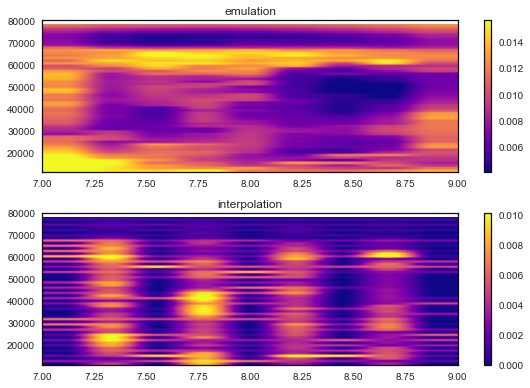

In [13]:
ranges = [[11000, None], [None, None]]
teffs, gravities, wref, spectra = process_grid('/Users/sl/Downloads/koester', 
                                              [3000, 9000], ranges)
emu2 = Emulator(wref, teffs[::2], gravities[::2], spectra[::2, ::2, :])
emu2.run_pca()

nteffs, nlogg = teffs.size, gravities.size
emulated_residuals = np.empty((nteffs, nlogg))
interpolated_residuals = np.empty((nteffs, nlogg))
for t_idx in range(nteffs):
    for g_idx in range(nlogg):
        err_em, err_int = test_residual(t_idx, g_idx)
        emulated_residuals[t_idx, g_idx] = err_em
        interpolated_residuals[t_idx, g_idx] = err_int

fig, axes = plt.subplots(nrows=2)
extents = (gravities.min(), gravities.max(), teffs.min(), teffs.max())
fig1 = imshow(emulated_residuals, axis=axes[0], aspect='auto', extent=extents)
fig2 = imshow(interpolated_residuals, axis=axes[1], aspect='auto', extent=extents)
cbar = fig.colorbar(fig1, ax=axes[0])
cbar2 = fig.colorbar(fig2, ax=axes[1])
axes[0].set_title('emulation')
axes[1].set_title('interpolation')
fig.tight_layout()    

## Conclusions

If you have SN ratios below 100, Scipy's `LinearNDInterpolator` is probably totally fine, otherwise emulation may help model fitting, by avoiding chisq dropping near grid points.